In [1]:
# general packages
import numpy as np
import pandas as pd
import datatable as dt
import gc

## 1. Data preposessing

In [2]:
%%time
#parse_dates = ['CreatedDate', 'RequestedDate', 'AccTime', 'PupTime', 'DelTime']
#A = pd.read_csv('Booking_Dispatch_training_set.csv', parse_dates = parse_dates, 
#date_parser = lambda x: pd.to_datetime(x).strftime("%Y-%m-%d %H:%M:%S"))
#data_parsed = A.to_csv('data_parsed.csv')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


In [3]:
%%time
#parse_dates = ['CreatedDate', 'RequestedDate']
#B = pd.read_csv('Booking_Dispatch_validation_set.csv', parse_dates = parse_dates, 
#date_parser = lambda x: pd.to_datetime(x).strftime("%Y-%m-%d %H:%M:%S"))
#data_parsed = B.to_csv('val_data_parsed.csv')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.29 µs


In [4]:
%%time
train_data_datatable = dt.fread('data_parsed.csv') 
data = train_data_datatable.to_pandas()
data = data.iloc[:,1:]

CPU times: user 20.9 s, sys: 17.4 s, total: 38.2 s
Wall time: 37.7 s


In [5]:
%%time
val_data_datatable = dt.fread('val_data_parsed.csv')
val_data = val_data_datatable.to_pandas()
val_data = val_data.iloc[:,1:]

CPU times: user 1.32 s, sys: 482 ms, total: 1.8 s
Wall time: 1.53 s


In [6]:
data.shape

(3000000, 37)

In [7]:
val_data.shape

(300000, 17)

In [8]:
#subtract the features and target variable for modeling 
train_features = data[['BookingSource','Conditions',
     'HasCondition','IsAccountBooking','CreatedDate','RequestedDate',
     'BookingFleet','DispatchFleet','AreaNumber','PuPlace','PuAddress',
     'PuSuburb','PuLat','PuLong','TargetVariable']]

In [9]:
val_features = val_data[['BookingSource','Conditions',
     'HasCondition','IsAccountBooking','CreatedDate','RequestedDate',
     'BookingFleet','DispatchFleet','AreaNumber','PuPlace','PuAddress',
     'PuSuburb','PuLat','PuLong','TargetVariable']]

In [10]:
train_features.head()

,BookingSource,Conditions,HasCondition,IsAccountBooking,CreatedDate,RequestedDate,BookingFleet,DispatchFleet,AreaNumber,PuPlace,PuAddress,PuSuburb,PuLat,PuLong,TargetVariable
0,TelOp,0,No,No,2019-04-11 10:36:55,2019-04-11 11:00:00,13cabs Sydney,13cabs Sydney,177,House,11 Stewart St,Randwick,-33.921022,151.244202,Completed
1,TelOp,0,No,No,2019-06-23 09:52:55,2019-06-23 09:52:55,13cabs Sydney,13cabs Sydney,111,,145 Alfred Rd,Narraweena,-33.755931,151.273028,Cancelled
2,Internet,0,No,No,2019-12-01 00:14:02,2019-12-01 00:14:02,13cabs Sydney,13cabs Sydney,92,,284 Birrell Street,Bondi,-33.897201,151.261205,Completed
3,StratumIVR,0,No,No,2019-09-12 09:07:03,2019-09-12 09:07:04,13cabs Sydney,13cabs Sydney,182,,127-131 Cook Rd,Centennial Park,-33.895716,151.228609,Completed
4,Internet,0,No,No,2019-02-21 21:37:04,2019-02-21 21:37:04,13cabs Sydney,13cabs Sydney,4,,Unit 87/5010 Macquarie St,Sydney,-33.859737,151.213307,Cancelled


In [11]:
val_features.head()

,BookingSource,Conditions,HasCondition,IsAccountBooking,CreatedDate,RequestedDate,BookingFleet,DispatchFleet,AreaNumber,PuPlace,PuAddress,PuSuburb,PuLat,PuLong,TargetVariable
0,StratumIVR,0,No,No,2019-03-07 16:24:17,2019-03-07 16:24:18,13cabs Sydney,13cabs Sydney,181,,42 Maddox St,Alexandria,-33.908468,151.193097,Completed
1,Internet,0,No,No,2019-07-27 14:47:45,2019-07-27 14:47:45,13cabs Sydney,13cabs Sydney,95,,16 Yarranabbe Rd,Darling Point,-33.872471,151.237137,Completed
2,TelOp,0,No,No,2019-01-15 11:36:47,2019-01-15 15:15:00,13cabs Sydney,Silver Service Sydney,221,House,107 Napier St,Drummoyne,-33.848875,151.155960,Completed
3,TelOp,0,No,No,2019-01-29 18:00:00,2019-01-29 18:00:00,13cabs Sydney,13cabs Sydney,197,Campsie Sydney Metro Station S,Lilian St,Campsie,-33.910592,151.103468,No Job
4,StratumIVR,0,No,No,2019-09-23 00:18:25,2019-09-23 00:18:25,13cabs Sydney,13cabs Sydney,179,,109 Alison Rd,Randwick,-33.912590,151.236801,Completed


In [12]:
#concatenate training data and validation data for feature engineering
features = pd.concat([train_features, val_features], axis=0).reset_index(drop=True)

In [13]:
# check datatypes
features.dtypes

BookingSource        object
Conditions            int64
HasCondition         object
IsAccountBooking     object
CreatedDate          object
RequestedDate        object
BookingFleet         object
DispatchFleet        object
AreaNumber            int32
PuPlace              object
PuAddress            object
PuSuburb             object
PuLat               float64
PuLong              float64
TargetVariable       object
dtype: object

In [25]:
# binary target: 'Cancelled'
target_dict = {'Cancelled':1,'Completed':0,'ELSE':0,'No Job':0,}
data['target_2cls_Cancelled'] = data['TargetVariable'].replace(target_dict)
val_data['target_2cls_Cancelled'] = val_data['TargetVariable'].replace(target_dict)

# binary target: 'Completed'
target_dict = {'Cancelled':0,'Completed':1,'ELSE':0,'No Job':0,}
data['target_2cls_Completed'] = data['TargetVariable'].replace(target_dict)
val_data['target_2cls_Completed'] = val_data['TargetVariable'].replace(target_dict)

# binary target: 'ELSE'
target_dict = {'Cancelled':0,'Completed':0,'ELSE':1,'No Job':0,}
data['target_2cls_ELSE'] = data['TargetVariable'].replace(target_dict)
val_data['target_2cls_ELSE'] = val_data['TargetVariable'].replace(target_dict)

# binary target: 'No Job'
target_dict = {'Cancelled':0,'Completed':0,'ELSE':0,'No Job':1,}
data['target_2cls_NoJob'] = data['TargetVariable'].replace(target_dict)
val_data['target_2cls_NoJob'] = val_data['TargetVariable'].replace(target_dict)

In [26]:
# 4分类target
target_dict2 = {
    'Cancelled':0,
    'Completed':1,
    'No Job':3,
    'ELSE':4,
}

data['target_4cls'] = data['TargetVariable'].replace(target_dict2)
val_data['target_4cls'] = val_data['TargetVariable'].replace(target_dict2)

In [27]:
data.head()

,BookingID,BookingSource,Conditions,HasCondition,IsAccountBooking,CreatedDate,RequestedDate,BookingFleet,DispatchFleet,VehicleID,...,Tolls,Tips,Discount,FinalDispatchStatus,TargetVariable,target_2cls_Cancelled,target_2cls_Completed,target_2cls_ELSE,target_2cls_NoJob,target_4cls
0,171970588,TelOp,0,No,No,2019-04-11 10:36:55,2019-04-11 11:00:00,13cabs Sydney,13cabs Sydney,602,...,0.0,0.0,0.0,Completed,Completed,0,1,0,0,1
1,174526964,TelOp,0,No,No,2019-06-23 09:52:55,2019-06-23 09:52:55,13cabs Sydney,13cabs Sydney,108,...,0.0,0.0,0.0,Cancelled,Cancelled,1,0,0,0,0
2,180286324,Internet,0,No,No,2019-12-01 00:14:02,2019-12-01 00:14:02,13cabs Sydney,13cabs Sydney,2868,...,0.0,0.0,0.0,Completed,Completed,0,1,0,0,1
3,177228281,StratumIVR,0,No,No,2019-09-12 09:07:03,2019-09-12 09:07:04,13cabs Sydney,13cabs Sydney,2330,...,0.0,0.0,0.0,Completed,Completed,0,1,0,0,1
4,170046024,Internet,0,No,No,2019-02-21 21:37:04,2019-02-21 21:37:04,13cabs Sydney,13cabs Sydney,-1,...,0.0,0.0,0.0,Cancelled,Cancelled,1,0,0,0,0


In [28]:
val_data.head()

,BookingID,BookingSource,Conditions,HasCondition,IsAccountBooking,CreatedDate,RequestedDate,BookingFleet,DispatchFleet,AreaNumber,...,PuSuburb,PuLat,PuLong,FinalDispatchStatus,TargetVariable,target_2cls_Cancelled,target_2cls_Completed,target_2cls_ELSE,target_2cls_NoJob,target_4cls
0,170605052,StratumIVR,0,No,No,2019-03-07 16:24:17,2019-03-07 16:24:18,13cabs Sydney,13cabs Sydney,181,...,Alexandria,-33.908468,151.193097,Completed,Completed,0,1,0,0,1
1,175644382,Internet,0,No,No,2019-07-27 14:47:45,2019-07-27 14:47:45,13cabs Sydney,13cabs Sydney,95,...,Darling Point,-33.872471,151.237137,Completed,Completed,0,1,0,0,1
2,168604643,TelOp,0,No,No,2019-01-15 11:36:47,2019-01-15 15:15:00,13cabs Sydney,Silver Service Sydney,221,...,Drummoyne,-33.848875,151.155960,Completed,Completed,0,1,0,0,1
3,169103600,TelOp,0,No,No,2019-01-29 18:00:00,2019-01-29 18:00:00,13cabs Sydney,13cabs Sydney,197,...,Campsie,-33.910592,151.103468,No Job,No Job,0,0,0,1,3
4,177600887,StratumIVR,0,No,No,2019-09-23 00:18:25,2019-09-23 00:18:25,13cabs Sydney,13cabs Sydney,179,...,Randwick,-33.912590,151.236801,Completed,Completed,0,1,0,0,1


In [13]:
#BookingSource variable
Conditions_count = data['Conditions'].value_counts().rename_axis('unique_values').reset_index(name='counts')
Conditions_count

,unique_values,counts
0,0,2240288
1,4194304,304956
2,64,101869
3,262144,88487
4,16777216,38880
...,...,...
375,537133056,1
376,604012544,1
377,17196908544,1
378,262152,1


In [14]:
#save the concatenated data
features_parsed = features.to_csv('feature1_parsed.csv')

## 2. Feature engineering

In [16]:
feature1 = features

In [17]:
%%time
#feature_data_datatable = dt.fread('feature1_parsed.csv') 
#feature1 = feature_data_datatable.to_pandas()
#feature1 = feature1.iloc[:,1:]

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


In [18]:
feature1.shape

(3300000, 15)

## 2.1 Location

In [20]:
import toad
from toad.plot import bin_plot

<AxesSubplot:xlabel='PuSuburb', ylabel='prop'>

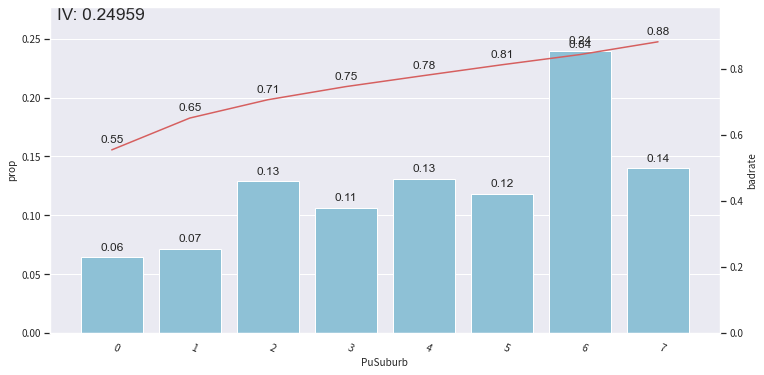

In [21]:
c = toad.transform.Combiner()
col = 'PuSuburb'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05) # DT, Kmeans, Quantile, Step 
bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')

<AxesSubplot:xlabel='PuSuburb', ylabel='prop'>

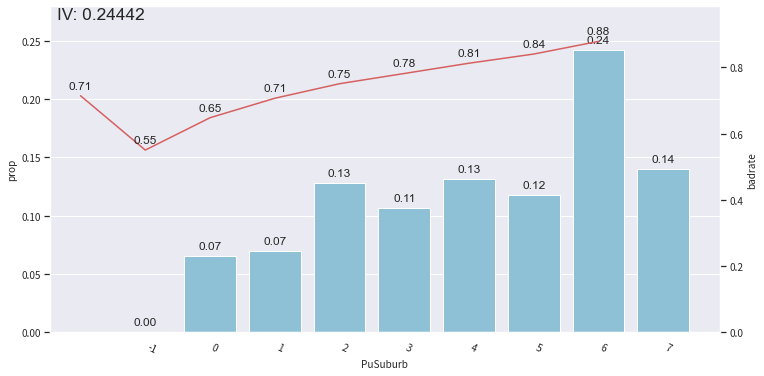

In [29]:
# 在test上测试
bin_plot(c.transform(val_data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed') 

In [30]:
# 由于-1的关系，有一个位移，忽视掉
#结论：train的IV0.2495，test时0.2444，稳定性非常好且iv很高；分箱的梯度非常明显

In [31]:
c.export()

{'PuSuburb': [['Bathurst',
   'Lithgow',
   'Brownlow Hill',
   'South Maroota',
   'Pitt Town',
   'Clarendon',
   'Lansdowne',
   'Windsor',
   'Hobartville',
   'Wollongong',
   'Bowenfels',
   'Glenmore',
   'South Windsor',
   'Audley',
   'Douglas Park',
   'Warrimoo',
   'Balmoral (South)',
   'Gosford',
   'Scotland Island',
   'Ku-Ring-Gai Chase',
   'Ebenezer',
   'Londonderry',
   'Cottage Point',
   'Wilton',
   'Oakdale',
   'Berkshire Park',
   'Cattai',
   'Palm Beach',
   'Whale Beach',
   'Springwood',
   'Oakville',
   'Mulgrave',
   'Mcgraths Hill',
   'Shanes Park',
   'The Oaks',
   'Port Kembla',
   'REGENTS PARK',
   'Sun Valley',
   'Werombi',
   'Lakesland',
   'Kelso',
   'Hill Top (North)',
   'HAYMARKET',
   'Belimbla Park',
   'Kurmond',
   'Vineyard',
   'Bligh Park',
   'Mount Vernon',
   'Agnes Banks',
   'Winmalee',
   'Windsor Downs',
   'Castlereagh',
   'Shalvey',
   'Bringelly',
   'WEST HOXTON',
   'Bilgola Beach',
   'Thirroul',
   'Wallerawang',


In [33]:
def PuSuburbBins(data,data_test):
    data = data.copy()
    data_test = data_test.copy()
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        c = toad.transform.Combiner()
        col = 'PuSuburb'
        c.fit(data[[col,target]], y = target, method = 'chi',min_samples = 0.05) 
        data['PuSuburbBins_'+val] = c.transform(data[['PuSuburb']], labels=False) # 纯分箱不做woe转化
        data_test['PuSuburbBins_'+val] = c.transform(data_test[['PuSuburb']], labels=False)
    return data, data_test

data, val_data = PuSuburbBins(data, val_data)

KeyboardInterrupt: 

### 2.1 New time features: 
booking by day, request by day, booking by hour, request by hour, create part of day, request part of day

In [77]:
# Changing the pickup_datetime and dropoff_datetime from object to datetime datatype
feature1['CreatedDate']=pd.to_datetime(feature1['CreatedDate'])
feature1['RequestedDate']=pd.to_datetime(feature1['RequestedDate'])

In [78]:
# Creating features based on day
feature1['create_by_day'] = feature1['CreatedDate'].dt.day_name()
feature1['request_by_day'] = feature1['RequestedDate'].dt.day_name()

In [79]:
# Creating features based on Hour
feature1['create_by_hour'] = feature1['CreatedDate'].dt.hour
feature1['request_by_hour'] = feature1['RequestedDate'].dt.hour
#Morning, which starts at 6:01 am and ends at 12:oopm
#Afternoon, which starts at 12:01 pm and ends at 18:00pm
#Evening, which starts at 18:01 and ends at 21:00pm
#Night, which start at 21:01 and ends at 6:00am

In [80]:
def part_of_day (t):
    if t in range (6,12):
        return "Morning"
    elif t in range (12,18):
        return "Afternoon"
    elif t in range (18,21):
        return "Evening"
    else:
        return "Night"

In [81]:
feature1['create_part_of_day']=feature1['create_by_hour'].apply(part_of_day)
feature1['request_part_of_day']=feature1['request_by_hour'].apply(part_of_day)

### 2.2 New feature: if booking fleet matches with the dispatch fleet(binary)

In [82]:
%%time
equal = list()
for i in range(feature1.shape[0]):
    if feature1['BookingFleet'][i] == feature1['DispatchFleet'][i]:
        equal.append('True')
    else:
        equal.append('False')

Wall time: 54.9 s


In [83]:
feature1['BookingisDispatch'] = equal

### 2.3 New feature: if the records of pick up surburbs exceed 10 (binary)

In [84]:
pick = feature1['PuSuburb'].value_counts().head(966).keys().tolist() #<10

In [85]:
feature1['pick'] = np.where(feature1['PuSuburb'].isin(pick), 1, 0)

### 2.4 Drop columns

In [86]:
gc.collect()

247

In [87]:
feature1 = feature1.drop(columns=['CreatedDate', 'RequestedDate']) #date features

In [88]:
feature1 = feature1.drop(columns=['PuSuburb','PuPlace','PuAddress']) # pick-up location related features

In [89]:
feature1.shape

(3300000, 18)

### 2.5 Encode categorical features

In [90]:
#cat = feature1[['BookingSource','BookingFleet','DispatchFleet','create_by_day',
#               'request_by_day','create_part_of_day','request_part_of_day']]

In [91]:
feature2 = pd.get_dummies(feature1).reset_index(drop=True)
feature2.shape

(3300000, 63)

In [94]:
feature2.iloc[0:10,:]

,Conditions,AreaNumber,PuLat,PuLong,create_by_hour,request_by_hour,pick,BookingSource_Internet,BookingSource_Permanent,BookingSource_StratumIVR,...,create_part_of_day_Afternoon,create_part_of_day_Evening,create_part_of_day_Morning,create_part_of_day_Night,request_part_of_day_Afternoon,request_part_of_day_Evening,request_part_of_day_Morning,request_part_of_day_Night,BookingisDispatch_False,BookingisDispatch_True
0,0,177,-33.921022,151.244202,10,11,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
1,0,111,-33.755931,151.273028,9,9,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
2,0,92,-33.897201,151.261205,0,0,1,1,0,0,...,0,0,0,1,0,0,0,1,0,1
3,0,182,-33.895716,151.228609,9,9,1,0,0,1,...,0,0,1,0,0,0,1,0,0,1
4,0,4,-33.859737,151.213307,21,21,1,1,0,0,...,0,0,0,1,0,0,0,1,0,1
5,0,253,-33.851305,151.186032,17,17,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1
6,0,27,-33.839003,151.234135,7,7,1,1,0,0,...,0,0,1,0,0,0,1,0,1,0
7,0,31,-33.834917,151.210208,18,7,1,1,0,0,...,0,1,0,0,0,0,1,0,0,1
8,524288,129,-33.799541,151.182911,4,12,1,0,0,0,...,0,0,0,1,1,0,0,0,1,0
9,0,274,-33.805868,151.021825,10,10,1,1,0,0,...,0,0,1,0,0,0,1,0,1,0


In [93]:
features_for_modelling = feature2.to_csv('features_processed.csv')